Install needed libraries

In [1]:
!pip -qq install pytorch_lightning==1.6.2
!pip -qq install -U segmentation-models-pytorch
!pip -qq install opencv-python
!pip install nibabel
!pip install kaggle

     |████████████████████████████████| 582 kB 12.3 MB/s 
     |████████████████████████████████| 419 kB 74.3 MB/s 
     |████████████████████████████████| 141 kB 69.2 MB/s 
     |████████████████████████████████| 596 kB 74.2 MB/s 
     |████████████████████████████████| 97 kB 3.5 MB/s 
     |████████████████████████████████| 376 kB 54.5 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount/Unmount google drive


In [ ]:
# Mount
#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)
# Unmount
#drive.flush_and_unmount()

Import needed packages

In [2]:
from collections import defaultdict
import os
import cv2
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import numpy as np
import nibabel as nib
from pathlib import Path
import pytorch_lightning as pl
from PIL import Image
import random
import segmentation_models_pytorch as pytorch_models
import torch
from torch import nn
#from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from typing import Optional
import pandas as pd

%load_ext tensorboard

Set up for Kaggel dataset download

In [3]:
#Upload kaggel API
from google.colab import files
uploaded = files.upload()
!pwd
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Saving kaggle.json to kaggle.json
/content


Download CT Covid Lung data (NIfTI) from Kaggle

In [4]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans
!unzip -qq covid19-ct-scans
!rm covid19-ct-scans.zip



 99% 1.02G/1.03G [00:04<00:00, 273MB/s]
100% 1.03G/1.03G [00:04<00:00, 261MB/s]


Look at metadata file information

In [5]:
metadata = pd.read_csv('metadata.csv')
#metadata.head()

## Get some information from metadata file and print it
column_names = list(metadata.columns.values)
print(column_names)
number_of_scans = len(metadata)
print(number_of_scans)
#row_values = list(metadata.values[:,0])

['ct_scan', 'lung_mask', 'infection_mask', 'lung_and_infection_mask']
20


Load an example for each data category via Nibabel

In [ ]:
# CT scans
ct_file = os.path.basename(metadata.loc[0,column_names[0]]) #Get scan filename from metadata
ct_scan = nib.load('ct_scans/' + ct_file) # load data
arr_ct = ct_scan.get_fdata() # get numpy array
print(arr_ct.shape)
slices_ct = arr_ct.shape[2]
print("Number of CT slices: " + str(slices_ct))

# Lung masks

lg_mask_file = os.path.basename(metadata.loc[0,column_names[1]])
lg_mask = nib.load('lung_mask/' + lg_mask_file)
arr_lg = lg_mask.get_fdata()

# Infection masks

inf_mask_file = os.path.basename(metadata.loc[0,column_names[2]])
inf_mask = nib.load('infection_mask/' + inf_mask_file)
arr_inf = inf_mask.get_fdata()

# Lung and infection masks

lg_inf_mask_file = os.path.basename(metadata.loc[0,column_names[3]])
lg_inf_mask = nib.load('lung_and_infection_mask/' + lg_inf_mask_file)
arr_lg_inf = lg_inf_mask.get_fdata()

(512, 512, 301)
Number of CT slices: 301


Data Visualization: Visualize a slice of the first scan to get a better idea of the dataset for further processing

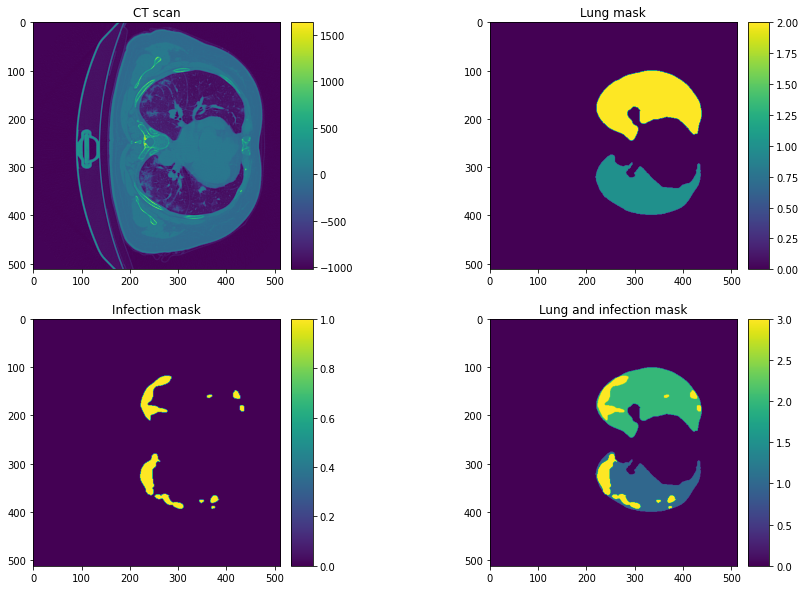

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,10))

# CT scan: Plot middle slice

slice_number = int(slices_ct/2)
ct = axes[0,0].imshow(arr_ct[:,:,slice_number])
axes[0,0].set_title('CT scan')
cax0 = fig.add_axes([axes[0,0].get_position().x1+0.01,axes[0,0].get_position().y0,0.02,axes[0,0].get_position().height])
fig.colorbar(ct, cax=cax0)

# Lung mask plot

lg = axes[0,1].imshow(arr_lg[:,:,int(slices_ct/2)])
axes[0,1].set_title('Lung mask')
cax1 = fig.add_axes([axes[0,1].get_position().x1+0.01,axes[0,1].get_position().y0,0.02,axes[0,1].get_position().height])
fig.colorbar(lg, cax=cax1)

# Infection mask plot 

inf = axes[1,0].imshow(arr_inf[:,:,int(slices_ct/2)])
axes[1,0].set_title('Infection mask')
cax2 = fig.add_axes([axes[1,0].get_position().x1+0.01,axes[1,0].get_position().y0,0.02,axes[1,0].get_position().height])
fig.colorbar(inf, cax=cax2)

# Lung and infection mask plot

lg_inf = axes[1,1].imshow(arr_lg_inf[:,:,int(slices_ct/2)])
axes[1,1].set_title('Lung and infection mask')
cax3 = fig.add_axes([axes[1,1].get_position().x1+0.01,axes[1,1].get_position().y0,0.02,axes[1,1].get_position().height])
fig.colorbar(lg_inf, cax=cax3)

plt.show()

Data preprocessing

In [6]:
class CTdata(Dataset):
  def __init__(self, cts_path: str, mask_path: str, balancing: bool = False, binary_lung: bool = False, pil_transform: Optional[transforms.Compose] = None):
    super().__init__()
    self.balancing = balancing
    self.pil_transform = pil_transform
    self.cts_path = cts_path
    self.mask_path = mask_path

    ## Load files
    # CT scan
    ct = nib.load(cts_path)
    self.ct_array = ct.get_fdata()
    self.len = self.ct_array.shape[2]
    # Mask
    mask = nib.load(mask_path)
    self.mask_array = mask.get_fdata()

    ## If binary segmentation for lung is wanted
    if binary_lung:
      self.mask_array[self.mask_array > 0.0] = 1.0 

    ## Balance data if needed
    if balancing:
      self.do_balance_data()

  def do_balance_data(self):
    print("This function is not yet implemented")
    raise NotImplementedError

  '''
  def __len__(self):
      return self.len

  def __getitem__(self, index):
      image = self.ct_array[:,:,index]
      image = Image.fromarray(np.uint8(image))
      if self.pil_transform is not None:
        image = self.pil_transform(image)
      seg_mask = self.mask_array[:,:,index]
      seg_mask = Image.fromarray(np.uint8(seg_mask))
      if self.pil_transform is not None:
          seg_mask = self.pil_transform(seg_mask)

      return image, seg_mask
  '''


Visualize CT data elements

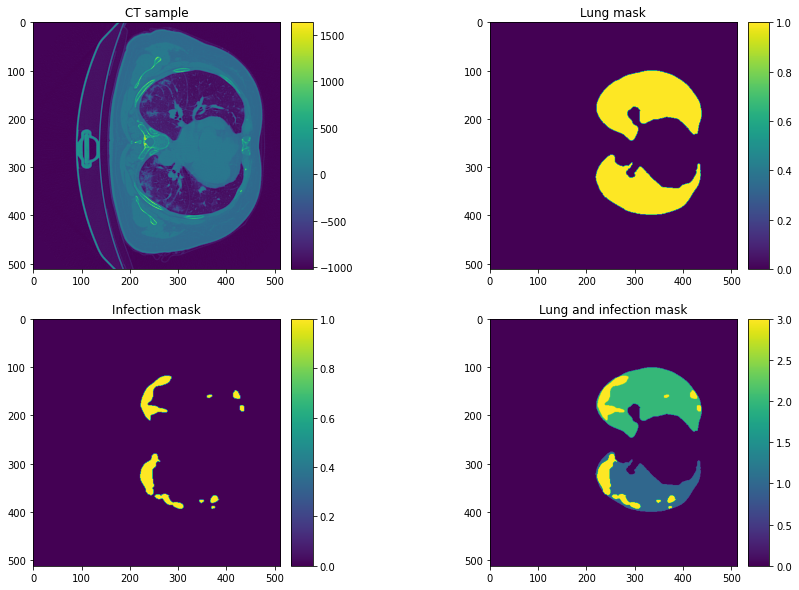

In [ ]:
## Get 150th slice (arbitrary choice) of first scan

filename_ct = os.path.basename(metadata.values[0,0])
filename_lg = os.path.basename(metadata.values[0,1])
filename_inf = os.path.basename(metadata.values[0,2])
filename_lg_inf = os.path.basename(metadata.values[0,3])
ct_path = os.path.join("ct_scans/", filename_ct)
lg_path = os.path.join("lung_mask/", filename_lg)
inf_path = os.path.join("infection_mask/", filename_inf)
lg_inf_path = os.path.join("lung_and_infection_mask", filename_lg_inf)

data_lg_mask = CTdata(ct_path, lg_path, binary_lung = True)
ct, lg_mask= data_lg_mask.__getitem__(150)

data_inf_mask = CTdata(ct_path, inf_path)
_, inf_mask = data_inf_mask.__getitem__(150)

data_lg_inf_mask = CTdata(ct_path, lg_inf_path)
_, lg_inf_mask = data_lg_inf_mask.__getitem__(150)

fig, axes = plt.subplots(2,2, figsize=(15,10))

# CT scan plot

ct_sample = axes[0,0].imshow(ct)
axes[0,0].set_title('CT sample')
cax0 = fig.add_axes([axes[0,0].get_position().x1+0.01,axes[0,0].get_position().y0,0.02,axes[0,0].get_position().height])
fig.colorbar(ct_sample, cax=cax0)

# Lung mask plot

lg = axes[0,1].imshow(lg_mask)
axes[0,1].set_title('Lung mask')
cax1 = fig.add_axes([axes[0,1].get_position().x1+0.01,axes[0,1].get_position().y0,0.02,axes[0,1].get_position().height])
fig.colorbar(lg, cax=cax1)

# Infection mask plot

inf = axes[1,0].imshow(inf_mask)
axes[1,0].set_title('Infection mask')
cax2 = fig.add_axes([axes[1,0].get_position().x1+0.01,axes[1,0].get_position().y0,0.02,axes[1,0].get_position().height])
fig.colorbar(inf, cax=cax2)

# Lung and infection mask plot

lg_inf = axes[1,1].imshow(lg_inf_mask)
axes[1,1].set_title('Lung and infection mask')
cax3 = fig.add_axes([axes[1,1].get_position().x1+0.01,axes[1,1].get_position().y0,0.02,axes[1,1].get_position().height])
fig.colorbar(lg_inf, cax=cax3)

plt.show()

Defining the network for pytorch lightning

In [7]:
class Segmentation(pl.LightningModule):
  def __init__(self, model, lr, loss, metric):
    super().__init__()
    self.backbone = model
    self.lr = lr
    self.loss = loss
    self.metric = metric
    self.writer = SummaryWriter()

  def forward(self, x):
    y = self.backbone(x)
    return y

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    y = y.unsqueeze(dim=1)
    y_pred = self.forward(x)
    loss = self.loss(y,y_pred)
    metric = self.metric(y,y_pred)
    self.writer.add_scalar('Train/Metric', metric)
    self.writer.add_scalar('Train/Loss', loss)
    return {"loss": loss, "metric": metric}

  def training_epoch_end(self,output):
    loss = 0
    metric = 0
    print(output)
    for o in output:
      curr_loss = o['loss']
      curr_metric = o['metric']
      loss += curr_loss
      metric += curr_metric
    loss = loss / len(output)
    metric = metric / len(output)
    self.writer.add_scalar('Epoch_loss/training', loss, self.current_epoch)
    self.writer.add_scalar('Epoch_metric/training', metric, self.current_epoch)

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    y = y.unsqueeze(dim=1)
    y_pred = self.forward(x)
    self.val_loss = self.loss(y,y_pred)
    metric = self.metric(y,y_pred)
    y_pred_plot = np.array(y_pred.cpu(), dtype=float)
    image = self.prepare_visualization(y[0, 0, :, :].cpu().numpy(), y_pred_plot[0, 0, :, :], x[0, 0, :, :].cpu().numpy())
    fig, ax = plt.subplots(nrows=1, ncols=4)
    ax[0].imshow(x[0, 0, :, :].cpu(),cmap="gray")
    ax[0].set_title('Image')
    ax[1].imshow(y[0, 0, :, :].cpu().numpy().astype("uint8"), cmap="gray")
    ax[1].set_title('GT Segm')
    ax[2].imshow(y_pred_plot[0, 0, :, :], cmap="gray")
    ax[2].set_title('Pred Segm')
    ax[3].imshow(image)
    ax[3].set_title('Overlay')
    self.writer.add_figure("Validation/"+str(batch_idx), fig, self.current_epoch)
    plt.close()
    return {"loss": self.val_loss, "metric": metric}

  def prepare_visualization(self,y,y_pred,image):
    annotation_pred = (y_pred>0.5).astype("uint8") # It will evaluate the logical expression y_predict>0.25 and return True or False 
    annotation_pred = np.uint8(annotation_pred)
    annotation_gt= np.uint8(y)

    overlay = np.copy(image) 
    image_label_overlay = label2rgb(annotation_pred, image=overlay, bg_label=0, alpha=0.5, colors=["red"])    
    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    redImg = np.zeros(image.shape, image.dtype)
    redImg[:,:] = (0, 255, 0)
    redMask = cv2.bitwise_and(redImg, redImg, mask=annotation_gt)
    image_mask1 = np.float32(image_label_overlay)
    image = cv2.addWeighted(redMask, 0.05, image_mask1, 0.95,0.0)
    return image


  def validation_epoch_end(self,output):
    loss = 0
    metric = 0
    for o in output:
      curr_loss = o['loss']
      curr_metric = o['metric']
      loss += curr_loss
      metric += curr_metric
    loss = loss / len(output)
    metric = metric / len(output)
    self.log('val_dice', metric)
    self.writer.add_scalar('Epoch_loss/validation', loss, self.current_epoch)
    self.writer.add_scalar('Epoch_metric/validation', metric, self.current_epoch)

Define segmentation model

In [8]:
pl.seed_everything(42) # Seed fixation

unet3 = pytorch_models.Unet(
    in_channels=1,                  
    classes=1,                      
    encoder_depth=3,                
    decoder_channels=(64, 32, 16),   
    encoder_weights = None,         
    activation = 'sigmoid'                 
    )


INFO:pytorch_lightning.utilities.seed:Global seed set to 42


In [9]:
!rm -rf runs
!rm -rf lightning_logs

Loss functions to test out



In [10]:
L1 = nn.L1Loss()

def dice_loss(ground_truth, prediction):
  ground_truth = ground_truth.view(-1)
  prediction = prediction.view(-1)
  intersect = torch.sum(ground_truth * prediction)
  sum = torch.sum(ground_truth) + torch.sum(prediction)
  loss = 1 - (2*intersect)/sum
  return loss

BCEStandard = nn.BCELoss()

## Loss functions for unbalanced data

#def focal_loss(ground_truth, prediction):

#BCEweighted = nn.BCELoss(weight=)

Metrics to try

In [11]:
## Jaccard Index
def jaccard(ground_truth, prediction):
  ground_truth = ground_truth.view(-1)
  prediction = prediction.view(-1)
  intersect = torch.sum(ground_truth * prediction)
  sum = torch.sum(ground_truth) + torch.sum(prediction) - intersect
  score = intersect/sum
  return score

## Dice Score
def dice_score(ground_truth, prediction):
  ground_truth = ground_truth.view(-1)
  prediction = prediction.view(-1)
  intersect = torch.sum(ground_truth * prediction)
  sum = torch.sum(ground_truth) + torch.sum(prediction)
  score = (2*intersect)/sum
  return score

Definition of the **hyperparameters** for model training

In [12]:
hyperparams = {"model": unet3, "batch_size": 32, "lr": 1e-3, "loss_func": BCEStandard, "metric": dice_score, "max_epochs": 10}

In [ ]:
# Define data splits for training and validation

data_splits = {}
data_splits['train'] = int(0.8*number_of_scans)
data_splits['val'] = int(0.1*number_of_scans)

# Define Transformations: Resize image and augment data for training set (max. of 5 degree rotation an ~10 pixel translation)
pil_transform_train = transforms.Compose([transforms.Resize((256, 256)), transforms.RandomAffine(5,(0.02,0.02)), transforms.ToTensor()])
pil_transform_val = transforms.Compose([transforms.Resize((256, 256)),  transforms.ToTensor()])   

pl.seed_everything(42) # Seed fixation

# Use nilearn to concatenate all the different .nii files into one

# Get the train and validation dataset. 
train_dataset = CTdata(cts_path=os.path.basename(metadata.values[0,0]),mask_path=os.path.basename(metadata.values[0,1]),pil_transform=pil_transform_train)
val_dataset = CTdata(cts_path=os.path.basename(metadata.values[0,0]),mask_path=os.path.basename(metadata.values[0,1]), pil_transform=pil_transform_val)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=hyperparams["batch_size"], shuffle=False, num_workers=2)

# Define the network
net = Segmentation(hyperparams["model"], lr=hyperparams["lr"], loss=hyperparams["loss_func"], metric=hyperparams["metric"])

# Define how and when to save the model during training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_dice',
    save_top_k=1,
    mode='max',
    every_n_epochs=1,
    save_last=True
)

trainer = pl.Trainer(precision=16, 
                    callbacks=checkpoint_callback,
                    check_val_every_n_epoch=1,
                    log_every_n_steps=5, 
                    max_epochs=hyperparams["max_epochs"])


Training

In [ ]:
trainer.fit(net, train_loader, val_loader)

In [ ]:
%tensorboard --logdir runs